#Conv MNIST AE

## Installation and imports

In [ ]:
!mkdir figures
!mkdir scripts
%cd /content/scripts
# !wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/pyprobml_utils.py
# !wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/lvm_plots_utils.py
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/ae-mnist-conv-latent-dim-2.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/ae-mnist-conv-latent-dim-20.ckpt
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/ae_mnist_conv.py

/content/scripts


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

try:
    import torch
except ModuleNotFoundError:
    %pip install torch
    import torch
import torch.nn as nn

try:
    from torchvision.datasets import MNIST
except ModuleNotFoundError:
    %pip install torchvision
    from torchvision.datasets import MNIST
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

try:
    from pytorch_lightning import LightningModule, Trainer
except ModuleNotFoundError:
    %pip install pytorch_lightning
    from pytorch_lightning import LightningModule, Trainer
try:
    from einops import rearrange
except ModuleNotFoundError:
    %pip install einops
    from einops import rearrange
import seaborn as sns

try:
    import umap
except:
    %pip install umap
    import umap

%pip install superimport

try:
    from probml_utils.lvm_plots_utils import (
        get_random_samples,
        get_grid_samples,
        plot_scatter_plot,
        get_imrange,
        plot_grid_plot,
    )
except:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils.lvm_plots_utils import (
        get_random_samples,
        get_grid_samples,
        plot_scatter_plot,
        get_imrange,
        plot_grid_plot,
    )


from torchvision.utils import make_grid
from pytorch_lightning.utilities.seed import seed_everything
from ae_mnist_conv import ConvAE

     |████████████████████████████████| 584 kB 4.0 MB/s 
     |████████████████████████████████| 596 kB 5.5 MB/s 
     |████████████████████████████████| 409 kB 42.1 MB/s 
     |████████████████████████████████| 136 kB 39.4 MB/s 
     |████████████████████████████████| 1.1 MB 15.4 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 271 kB 36.2 MB/s 
     |████████████████████████████████| 144 kB 48.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=f61e5f2ac71eabc38010a43caec47f88470469404f0754beec34013dda56efd9
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap
  Created wheel for superimport: filename=superimport-0.3.4-py3-none-any.whl size=5888 sha256=abdad212a3d62ec32a4c8

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
mnist_full = MNIST(".", download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))

dm = DataLoader(mnist_full, batch_size=512, shuffle=True)

vis_data = DataLoader(mnist_full, batch_size=5000)
batch = next(iter(vis_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Basic Conv VAE Module

In [ ]:
ae = ConvAE((1, 28, 28), encoder_conv_filters=[28, 64, 64], decoder_conv_t_filters=[64, 28, 1], latent_dim=20)
ae.load_state_dict(torch.load("ae-mnist-conv-latent-dim-20.ckpt"))
ae.to(device)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpwnz2_i_c
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpwnz2_i_c/_remote_module_non_sriptable.py


ConvAE(
  (vae): ConvAEModule(
    (enc_convs): ModuleList(
      (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(28, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01)
    )
    (mu_linear): Sequential(
      (0): Linear(in_features=1024, out_features=20, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.2, inplace=False)
    )
    (log_var_linear): Sequential(
      (0): Linear(in_features=1024, out_features=20, bias=True)
      (1): LeakyReLU(nega

In [ ]:
ae2 = ConvAE((1, 28, 28), encoder_conv_filters=[28, 64, 64], decoder_conv_t_filters=[64, 28, 1], latent_dim=2)
ae2.load_state_dict(torch.load("ae-mnist-conv-latent-dim-2.ckpt"))
ae2.to(device)

ConvAE(
  (vae): ConvAEModule(
    (enc_convs): ModuleList(
      (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(28, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.01)
    )
    (mu_linear): Linear(in_features=1024, out_features=2, bias=True)
    (log_var_linear): Linear(in_features=1024, out_features=2, bias=True)
    (decoder_linear): Linear(in_features=2, out_features=1024, bias=True)
    (dec_t_convs): ModuleList(
      (0): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
      (1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): LeakyReLU(negative_slope=0.01)
      (3): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
      (4): ConvTranspose2d(64, 28, kernel_size=(3, 3), stride=(1, 1), paddin

## Reconstruction

### ConvAE with latent dim 20

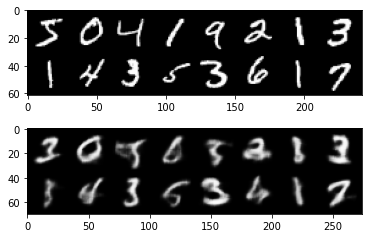

In [ ]:
imgs, _ = batch
imgs = imgs[:16]

fig, axs = plt.subplots(2, 1)
axs[0].imshow(rearrange(make_grid(imgs), "c h w -> h w c"))
imgs = imgs.to(device=device)
axs[1].imshow(rearrange(make_grid(ae.vae(imgs)[0].cpu()), "c h w -> h w c"))
plt.savefig("../figures/ae_mnist_conv_20d_rec.pdf")
plt.show()

### ConvAE with latent dim 2

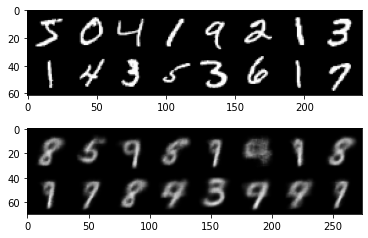

In [ ]:
imgs, _ = batch
imgs = imgs[:16]

fig, axs = plt.subplots(2, 1)
axs[0].imshow(rearrange(make_grid(imgs), "c h w -> h w c"))
imgs = imgs.to(device=device)
axs[1].imshow(rearrange(make_grid(ae2.vae(imgs)[0].cpu()), "c h w -> h w c"))
plt.savefig("../figures/ae_mnist_conv_2d_rec.pdf")
plt.show()

In [ ]:
def decoder_ae(z):
    return ae.vae.decode(z)


def decoder_ae2(z):
    return ae2.vae.decode(z)


def decoder_ae_index(z):
    return ae.vae.decode(z)[0]


def decoder_ae2_index(z):
    return ae2.vae.decode(z)[0]


def decoder_ae_rearrange(z):
    z = z.to(device)
    return rearrange(ae.vae.decode(z), "b c h w -> b (c h) w")


def decoder_ae2_rearrange(z):
    z = z.to(device)
    return rearrange(ae2.vae.decode(z), "b c h w -> b (c h) w")


def encoder_ae_index(img):
    return ae.vae.encode(img)[0]


def encoder_ae2_index_numpy(img):
    return ae2.vae.encode(img)[0].cpu().detach().numpy()


def encoder_ae_index_detach(img):
    return ae.vae.encode(img)[0].cpu().detach()


def encoder_ae2_index_detach(img):
    return ae2.vae.encode(img)[0].cpu().detach()

## Sampling

### Random samples from truncated normal distribution 

We sample $z \sim TN(0,1)$ form a truncated normal distribution with a threshold = 5


#### ConvAE with latent dim 20

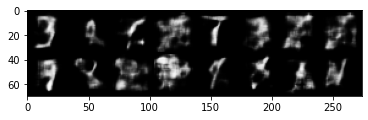

In [ ]:
plt.figure()
imgs = get_random_samples(decoder_ae, truncation_threshold=5, latent_dim=20, num_images_per_row=8, num_images=16)
plt.imshow(imgs)
plt.savefig("../figures/ae_mnist_conv_20d_samples.pdf")

#### ConvAE with latent dim 2

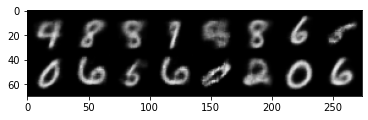

In [ ]:
plt.figure()
imgs = get_random_samples(decoder_ae2, truncation_threshold=5, latent_dim=2, num_images_per_row=8, num_images=16)
plt.imshow(imgs)
plt.savefig("../figures/ae_mnist_conv_2d_samples.pdf")

### Grid Sampling

#### ConvAE with latent dim 20

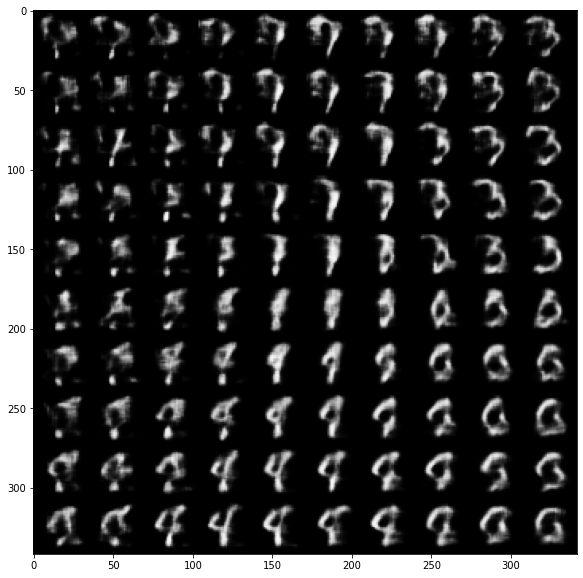

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(make_grid(get_grid_samples(decoder_ae_index, 20), 10), " c h w -> h w c").cpu())

#### ConvAE with latent dim 2

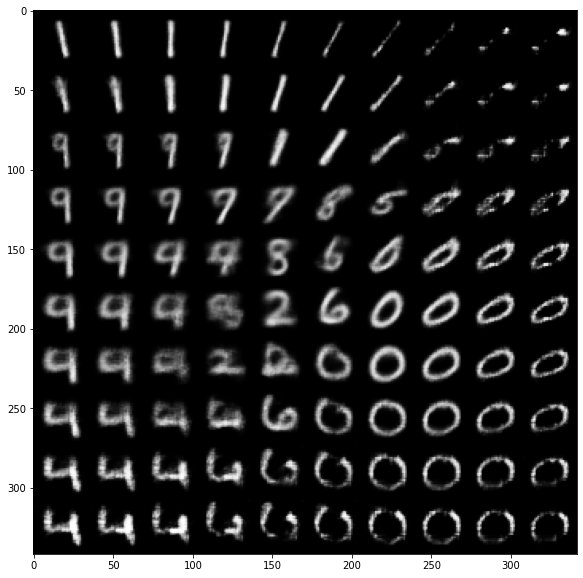

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(make_grid(get_grid_samples(decoder_ae2_index, 2), 10), " c h w -> h w c").cpu())

## 2D Color embedding of latent space

### ConvVAE with latent dim 20

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


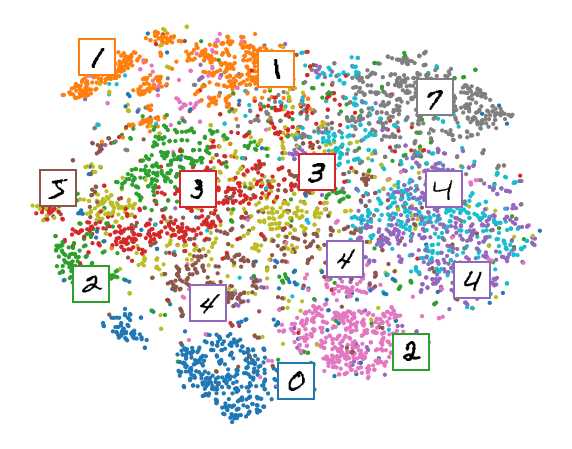

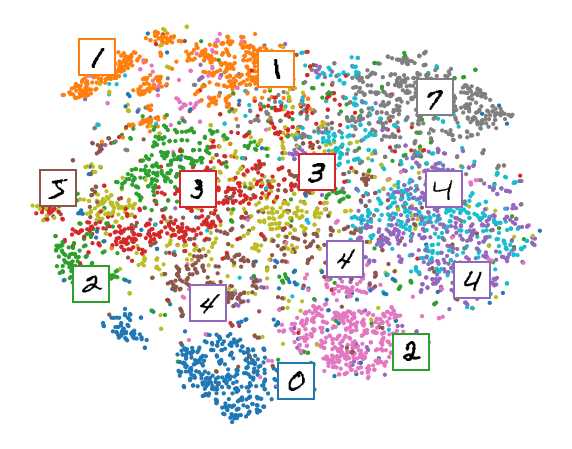

In [ ]:
plot_scatter_plot(batch, encoder_ae_index)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


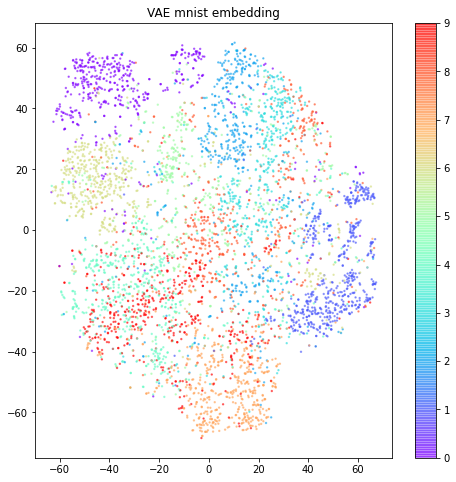

In [ ]:
fig = plot_grid_plot(batch, encoder_ae_index)
fig.savefig("../figures/ae_mnist_conv_20d_embed.pdf")
plt.show()

### ConvAE with latent dim 2

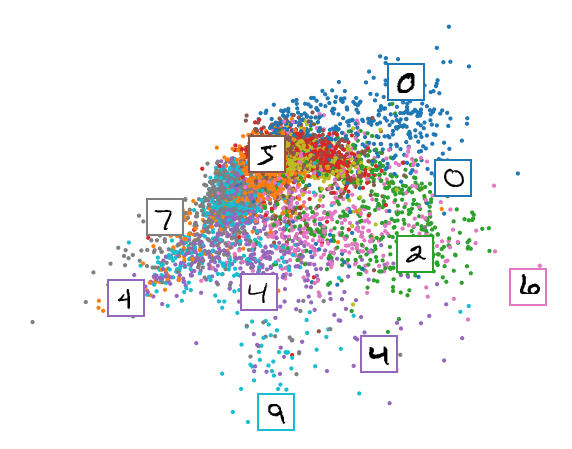

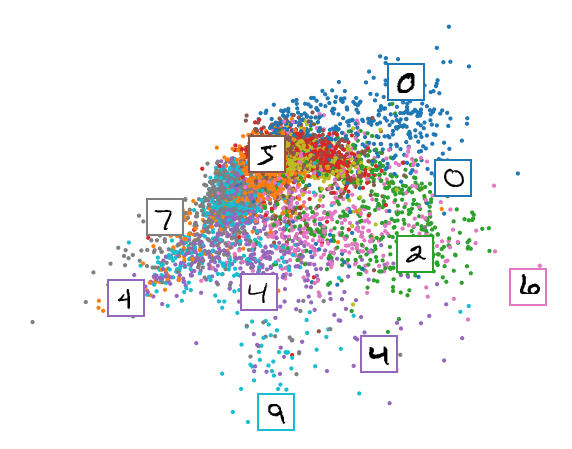

In [ ]:
plot_scatter_plot(batch, encoder_ae2_index_numpy)

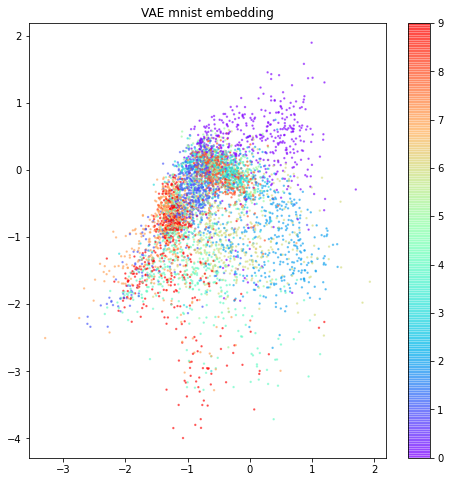

In [ ]:
fig = plot_grid_plot(batch, encoder_ae2_index_numpy)
fig.savefig("../figures/ae_mnist_conv_2d_embed.pdf")
plt.show()

## Interpolation

### Spherical Interpolation

#### ConvAE with latent dim 20

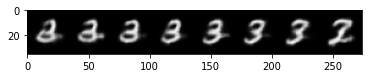

In [ ]:
imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder_ae_index_detach(imgs)
# end, start = z_imgs[1], z_imgs[3]
end, start = z_imgs[0], z_imgs[5]

plt.figure()
arr = get_imrange(decoder_ae_rearrange, start, end, interpolation="spherical")
plt.imshow(arr)

#### ConAE with latent dim 2

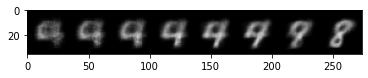

In [ ]:
imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder_ae2_index_numpy(imgs)
# end, start = z_imgs[1], z_imgs[3]
end, start = z_imgs[0], z_imgs[5]
start = torch.from_numpy(start)
end = torch.from_numpy(end)

plt.figure()
arr = get_imrange(decoder_ae2_rearrange, start, end, interpolation="spherical")
plt.imshow(arr)

### Linear Interpolation

#### ConvAE with latent dim 20

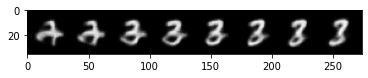

In [ ]:
imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder_ae_index_detach(imgs)
# end, start = z_imgs[1], z_imgs[3]
end, start = z_imgs[0], z_imgs[5]

plt.figure()
arr = get_imrange(decoder_ae_rearrange, start, end, interpolation="linear")
plt.imshow(arr)
plt.savefig("../figures/ae_mnist_conv_20d_linear.pdf")

#### ConvAE with latent dim 2

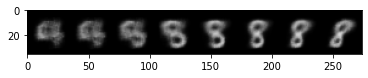

In [ ]:
imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder_ae2_index_detach(imgs)
# end, start = z_imgs[1], z_imgs[3]
end, start = z_imgs[0], z_imgs[5]

plt.figure()
arr = get_imrange(decoder_ae2_rearrange, start, end, interpolation="linear")
plt.imshow(arr)
plt.savefig("../figures/ae_mnist_conv_2d_linear.pdf")